In [1]:
# Download all packages 
import pickle
import detritalpy.detritalFuncs as dFunc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from random import choices
from random import randrange
from random import randint
import random
import time
from drs import drs

In [2]:
# Lets load in the original sources
sims_data = pickle.load(open('New 0.95-0.99 Sources.p','rb'))

In [3]:
# Lets load all of the data into a dataframe
IDs = []
KDEs = []
sources = []
for entry in sims_data:
    ID = entry
    IDs.append(ID)
    KDEs.append(sims_data[entry][0])
    sources.append(sims_data[entry][1])

In [4]:
df = pd.DataFrame()
df['ID'] = IDs
df['KDE'] = KDEs
df['Sources'] = sources

In [5]:
df

,ID,KDE,Sources
0,0,"[7.88581148895006e-40, 1.1951995152124526e-39,...","[[4.749422788040255e-73, 8.56928972593199e-73,..."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 4.749422788040255e-7...","[[0.0, 0.0, 0.0, 0.0, 0.0, 4.749422788040255e-..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,4,"[7.880788438900995e-40, 1.1944225463133285e-39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,5,"[0.0, 4.749422788040255e-74, 8.56928972593199e...","[[0.0, 4.749422788040255e-73, 8.56928972593199..."
6,6,"[0.0, 0.0, 0.0, 5.0230500490640555e-43, 7.7696...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


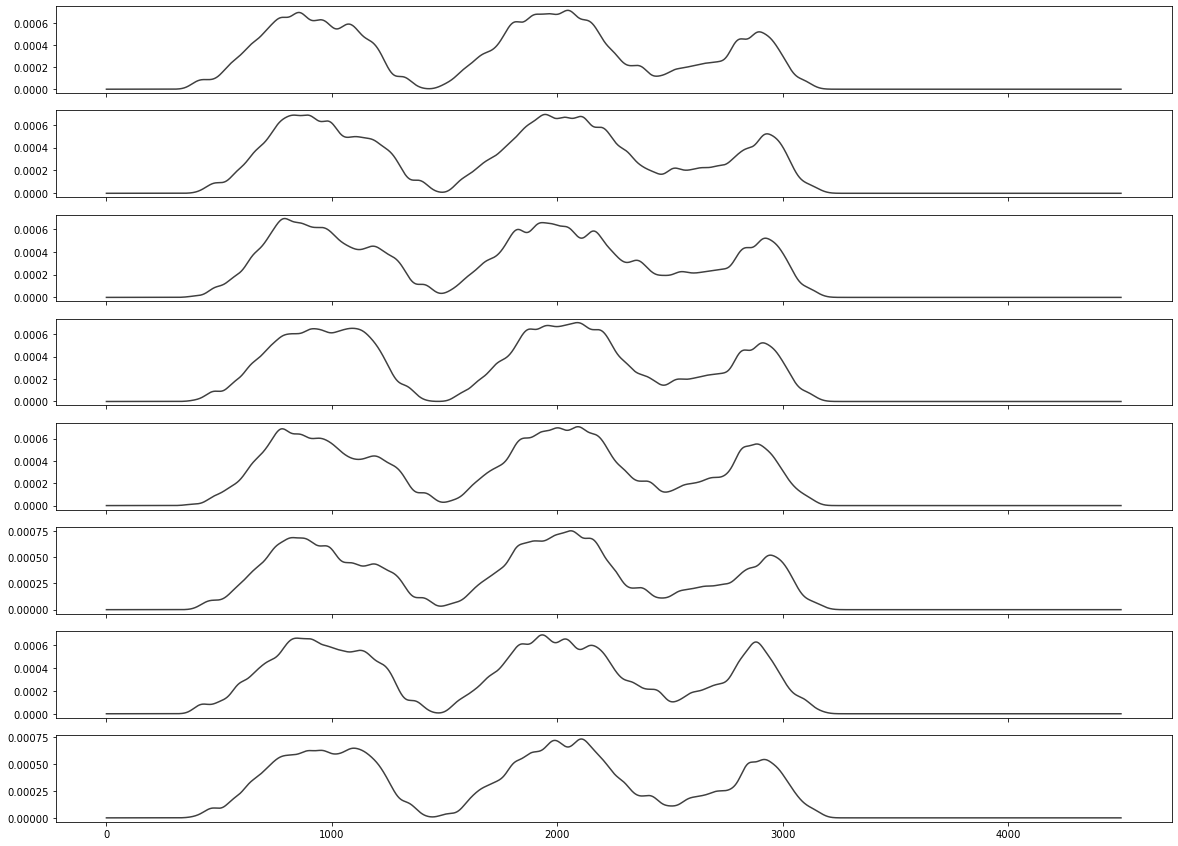

In [6]:
plt.rcParams['figure.figsize'] = [20, 15]
fig,axs = plt.subplots(len(KDEs),sharex=True)
for i in range(len(KDEs)):
    axs[i].plot(KDEs[i],color='black',alpha=0.75)

In [7]:
# Now we want to go through and create synthetic KDEs from each of the parent samples
# The model will be tested on variable number of soures vs variable number of grains drawn from the PDF
# For each parent I will need to generate 1000 KDEs with 10-300 grains drawn in intervals of 5
# These will be stored in a dictionary with key [parent, grains]

In [8]:
###########################################
# Presets
bw = 15
xdif = 1
hit_vals = np.round(np.logspace(1,3,num=35),0)
###########################################
# start a timer
start_time = time.time()
final_synth_dict = {}
# t will be the number of sources
for t in range(1,2):
    # Grab the KDE we will be working with
    index_KDE = [df.loc[t]['KDE']]
    index_source = df.loc[t]['Sources']
    # Create a list of ages from a given probability
    index_age = []
    for r in range(0,500):
        pick = np.random.choice(np.arange(0,4501), p = np.sum(index_KDE,axis = 0)/np.sum(index_KDE))
        index_age.append(pick)
    init_KDE_age, init_KDE = dFunc.KDEcalcAges_2(index_age,x1=0,x2=4500,xdif=xdif,bw=bw,cumulative = False)
    # w will be the number of grains utilized
    for w in hit_vals:
        total_KDE_list = []
        w = int(w)
        for i in range(0,1000):
            # INTRODUCE PROPORTION VARIABILITY ######################################
            new_index_sources = []
            # ADJUSTING SOURCES #####################################################
            
            drs_coeff = drs(len(index_source),5)
            for i in range(len(index_source)):
                ind_source = index_source[i]
                ind_drs = drs_coeff[i]
                new_ind_source = []
                for var in ind_source:
                    new_var = var*ind_drs
                    new_ind_source.append(new_var)
                new_ind_source = np.asarray(new_ind_source)
                new_index_sources.append(new_ind_source)
            new_index_KDE = sum(new_index_sources)
            
            # FOR A SET RANGE #######################################################
            
            #start = random.randint(0,1500)
            #end = random.randint(1500,3200)
            # Now set the drs split percent for the range
            #split_num = random.randint(2,20)
            #drs_sets = drs(split_num,1)
            #split_percent = random.choice(drs_sets)
            #index = 0
            #for item in index_KDE[0]:
            #    if start<=index<=end:
            #        new_item = item*split_percent
            #        new_index_KDE.append(new_item)
            #        index +=1
            #  elif index<=start or index>=end:
            #        new_index_KDE.append(item)
            #        index+=1
            
            # COMPLETELY RANDOM AMOUNTS ############################################
            
            #for item in index_KDE[0]:
             #   split_num = random.randint(25,100)
              #  drs_items = drs(split_num,item)
               # new_item = random.choice(drs_items)
                #new_index_KDE.append(new_item)
                
            ########################################################################
            new_index_KDE = [np.asarray(new_index_KDE)]
            #########################################################################
            
            source_dist = [np.random.choice(init_KDE_age, size = w, p = np.sum(new_index_KDE, axis = 0)/np.sum(new_index_KDE))]
            source_KDE_age, source_KDE = dFunc.KDEcalcAges_2(source_dist, x1=0, x2=4500, xdif=xdif, bw=bw, cumulative=False)
            source_KDE = source_KDE[0]
            total_KDE_list.append(source_KDE)
        final_synth_dict[t,w] = total_KDE_list
        end_time = time.time()
        total_time = end_time-start_time
        print('Finished with sample',t,'analyses',w)
        print('Total Run Time:',total_time)

Finished with sample 1 analyses 10
Total Run Time: 16.752384901046753
Finished with sample 1 analyses 11
Total Run Time: 33.60118508338928
Finished with sample 1 analyses 13
Total Run Time: 50.70600628852844
Finished with sample 1 analyses 15
Total Run Time: 68.43196678161621
Finished with sample 1 analyses 17
Total Run Time: 87.18952107429504
Finished with sample 1 analyses 20
Total Run Time: 107.14894199371338
Finished with sample 1 analyses 23
Total Run Time: 128.00107097625732
Finished with sample 1 analyses 26
Total Run Time: 151.4193205833435
Finished with sample 1 analyses 30
Total Run Time: 179.31253743171692
Finished with sample 1 analyses 34
Total Run Time: 208.37302947044373
Finished with sample 1 analyses 39
Total Run Time: 239.28574180603027
Finished with sample 1 analyses 44
Total Run Time: 272.4908607006073
Finished with sample 1 analyses 51
Total Run Time: 308.26343965530396
Finished with sample 1 analyses 58
Total Run Time: 346.7225248813629
Finished with sample 1 anal

In [9]:
pickle.dump(final_synth_dict,open('0.95-0.99 1 Variable Sources.p','wb'))

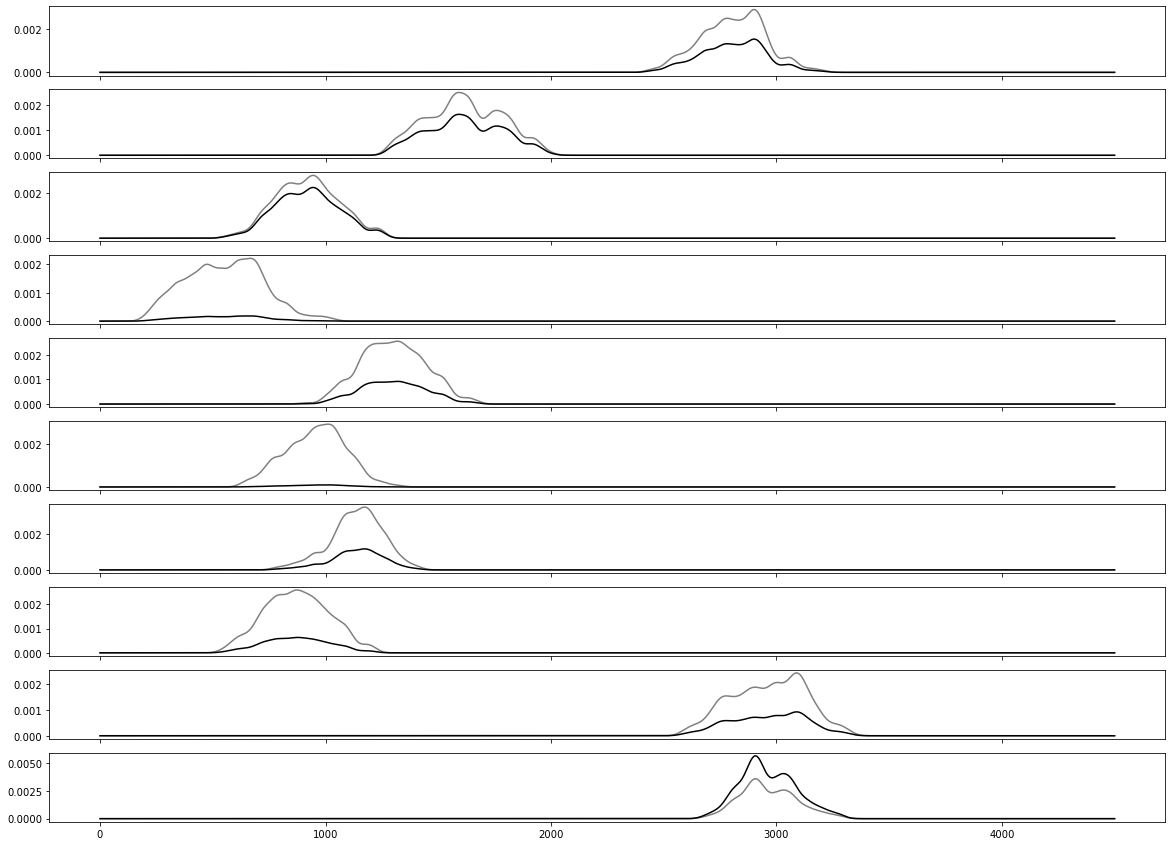

In [44]:
plt.rcParams['figure.figsize'] = [20, 15]
fig,axs = plt.subplots(len(new_index_sources),sharex=True)
for i in range(len(new_index_sources)):
    axs[i].plot(new_index_sources[i],color='black',alpha=1)
    axs[i].plot(index_source[i],color='black',alpha=0.5)

In [9]:
pickle.dump(final_synth_dict,open('0.15-0.25 0 Variable Sources.p','wb'))